# 서포트 벡터 머신

서포트 벡터 머신(SVM, Support Vector Machine)은 분류와 회귀 분석에 모두 사용할 수 있는 특히 강력하고 유연한 지도 학습 알고리즘이다. 이번 절에서는 서포트 벡터 머신에 대한 직관을 기르고 이를 분류 문제에 활용하는 법을 알아보겠다. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

## 서포트 벡터 머신의 동기

앞에서 베이즈 분류에 대해 다룰 때 각 기반 클래스의 분포를 설명하는 간단한 모델을 배웠고 이 생성 모델을 사용해 확률적으로 새 점의 레이블을 결정했다. 거기서는 생성 분류의 일례로 다뤘지만 여기서는 그 대신 판별 분류(discriminative classification)로 알아보겠다. 다시 말해, 각 클래스를 모델링하기보다는 간단히 클래스를 서로 나누는 선이나 곡선, 다양체를 구할 것이다. 

이에 대한 예제로 두 클래스로 잘 구분되어 있는 간단한 분류 작업을 생각해보자.

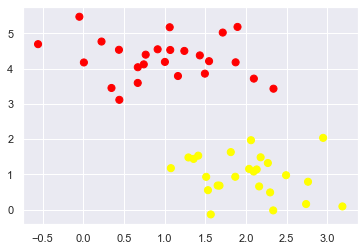

In [3]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

선형 판별 분류기는 두개의 데이터 집합을 분리하는 직선을 그려서 분류 모델을 만들고자 할 것이다. 여기서 보여준 것과 같은 2차원 데이터의 경우에 이 작업은 직접 할 수도 있다. 그러나 이 두 클래스 사이를 완벽하게 구별할 수 있는 구분선이 하나 이상 있다는 문제점을 바로 발견하게 될 것이다.

그 구분 선을 다음과 같이 그릴 수 있다. 

(-1.0, 3.5)

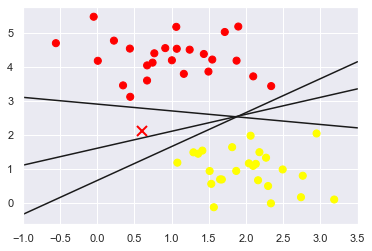

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3.5)

이 세개의 구분자는 서로 매우 다르지만 표본들 사이를 완벽하게 판별한다. 어느 것을 선택하느냐에 따라 새로운 데이터 점에 항ㄹ당되는 레이블이 달라질 것이다. 단순한 직관으로 '클래스 사이에 선을 그리는 것'만으로는 충분하지 않으며 조금 더 깊이 생각해야 한다.

## 서포트 벡터 머신 : 마진 최대화

서포트 벡터 머신은 이 문제를 개선하는 한 가지 방법을 제공한다. 직관적으로 클래스 사이에 단순히 폭이 0인 선을 그리는 것이 아니라 각 선에서 주변의 가장 가까운 점에 이르는 너비의 마진을 그리는 것이다. 서포트 벡터 머신에서는 이 마직은 극대화하는 건이 최적의 모델이 된다. 서포트 벡터 머신은 이러한 **최대 마진 추정기**의 대표적인 예다.

이 데이터에 실제 적합한 결과를 살펴보자. 당분간 선형 커널을 사용하고 모수 $C$에 매우 큰 수를 설정할 것이다. 

In [5]:
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

여기서 무슨 일이 일어나고 있는지 더 잘 확인하기 위해 SVM 결정 경계를 플로팅 할 간단한 함수를 만들어보자. 

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    # 2차원 SVC를 위한 의사결정 함수 플로팅하기
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 모델 평가를 위한 그리드 생성
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 의사 결정 경계와 마진 플로팅
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyle=['--', '-', '--'])
    # 서포트 벡터 플로팅
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s = 300, linewidth=1, facecolors='none')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

/Users/a1101497/opt/anaconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'


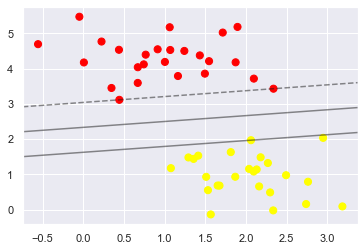

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);